NameError: name 'ax2' is not defined

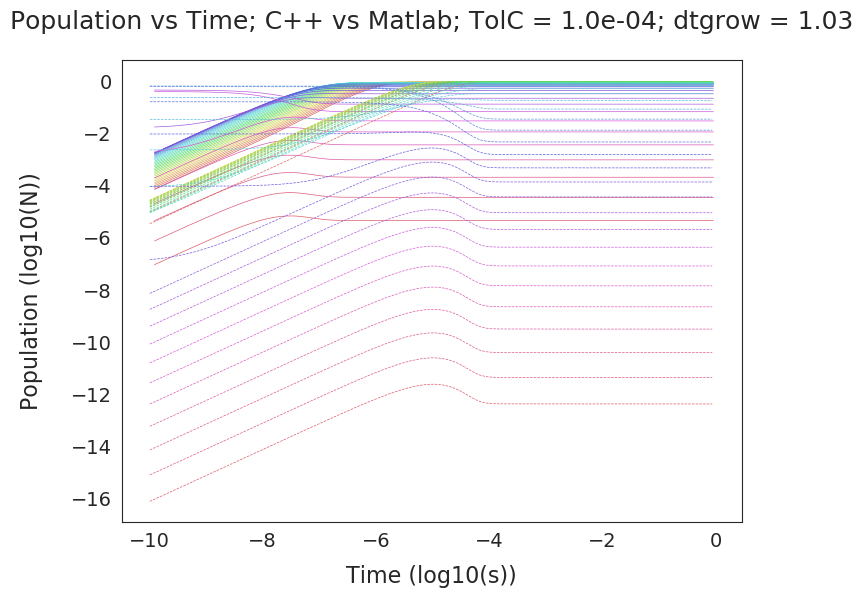

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Parameters
n_plotfiles = 198 #Enter the number of plotfiles you have
scheme = "PE" #Enter the scheme you are testing
model_number = "3" #Enter the model you are using (1, 3, or 5)


# Function to load data from files
def load_data(file_dir, file_prefix, num_files, cpp=True):
    t_values = []
    N_values = []
    for i in range(num_files):
        if cpp:
            filename = os.path.join(file_dir, f"PlotFile_{i}")
        else:
            filename = os.path.join(file_dir, f"PlotFile_{i+1}")    
        
        with open(filename, "r") as f:
            if cpp:
                N = []
                for line in f:
                    if line.startswith("tolPE:"):            
                        tolPE = float(line.split(":")[1])
                    if line.startswith("t:"):
                        t = float(line.split(": ")[1])
                    elif line.startswith("N:"):
                        N_line = line.split(": ")[1].strip()
                        N.append(np.array([float(x) for x in N_line.split()]))
            else:
                lines = f.readlines()
                t_index = lines.index("t\n") + 1
                t = float(lines[t_index].strip())
                N_index = lines.index("N\n") + 1
                N = []
                while True:
                    try:
                        N.append(float(lines[N_index].strip()))
                        N_index += 1
                    except ValueError:
                        break
        
        t_values.append(t)
        N_values.append(N)
    
    t_array = np.array(t_values)
    N_array = np.array(N_values)
    
    if not cpp:
        N_array = N_array.reshape(len(N_array), 1, -1)

    return t_array, N_array


# Load C++ data
file_dir_cpp = "/home/jared/FENN/Output"
t_array_cpp, N_array_cpp = load_data(file_dir_cpp, "PlotFile_", 150)

# Load Matlab data
file_dir_matlab = "/home/jared/NeutrinoTransportTesting/MATLAB_MICS/Translated"
t_array_matlab, N_array_matlab = load_data(file_dir_matlab, "PlotFile_", 150, cpp=False)

# Apply log10 to the arrays
t_log_array_cpp = np.log10(t_array_cpp)
N_log_array_cpp = np.log10(N_array_cpp)
t_log_array_matlab = np.log10(t_array_matlab)
N_log_array_matlab = np.log10(N_array_matlab)

# Perform the RMS error calculation for each time step
RMS_array = np.zeros((150,))
for i in range(1, 150):
    # Get the reference and approximation calculations for this time step
    R = N_array_matlab[i, :]
    A = N_array_cpp[i - 1, :].reshape(N_array_matlab.shape[1], -1)

    # Calculate the residuals for each N value and sum them
    Res = np.abs(A - R)
    StepRes = np.sum(Res)

    # Calculate the RMS error
    RMS = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))

    # Add the RMS error to the array
    RMS_array[i - 1] = RMS

# Find the maximum RMS error and the time step at which it occurs
max_RMS_error = np.max(RMS_array)
max_error_idx = np.unravel_index(np.argmax(RMS_array, axis=None), RMS_array.shape)
max_error_time = t_array_matlab[max_error_idx[0]]

# Set up the plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the 'colors' variable using hls_palette
num_colors = N_log_array_cpp.shape[2]
colors = sns.color_palette("hls", num_colors)


# Plot C++ data with straight lines
for i in range(N_log_array_cpp.shape[2]):
    ax.plot(t_log_array_cpp[1:], N_log_array_cpp[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2)

# Plot Matlab data with dashed lines
for i in range(N_log_array_matlab.shape[2]):
    ax.plot(t_log_array_matlab[1:], N_log_array_matlab[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

ax.set_xlabel("Time (log10(s))", fontsize=16, labelpad=10)
ax.set_ylabel("Population (log10(N))", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add title
ax.set_title("Population vs Time; C++ vs Matlab; TolC = 1.0e-04; dtgrow = 1.03", fontsize=18, y=1.05)
# Add titles
ax2.set_title(f"Population vs Time; {scheme}; Model {model_number}; TolPE = {tolPE} ", fontsize=18, y=1.05)
# Create a custom legend with visual distinctions
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

ax.legend(custom_lines, ['C++', 'Matlab'], loc='lower right')

# Add RMS error box with a smaller size
ax.text(0.50, 0.05, f"Max RMS Error: {max_RMS_error:.3f}", transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, pad=3))

#plt.savefig("Pop_vs_time_Intermidiate_Model_1.eps", dpi=300, bbox_inches="tight")

plt.show()



In [3]:
# Perform the RMS error calculation for each time step
RMS_array_cpp = np.zeros((99,))
RMS_array_matlab = np.zeros((99,))
for i in range(1, 100):
    # Get the reference and approximation calculations for this time step
    R = N_array_matlab[i, :]
    A = N_array_cpp[i - 1, :].reshape(N_array_matlab.shape[1], -1)

    # Calculate the residuals for each N value and sum them
    Res = np.abs(A - R)

    # Calculate the RMS error for C++ data
    RMS_cpp = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))
    RMS_array_cpp[i - 1] = RMS_cpp

    # Calculate the RMS error for Matlab data
    RMS_matlab = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))
    RMS_array_matlab[i - 1] = RMS_matlab

# Find the maximum RMS error and the time step at which it occurs for each case
max_RMS_error_cpp = np.max(RMS_array_cpp)
max_error_idx_cpp = np.unravel_index(np.argmax(RMS_array_cpp, axis=None), RMS_array_cpp.shape)
max_error_time_cpp = t_array_matlab[max_error_idx_cpp[0]]

max_RMS_error_matlab = np.max(RMS_array_matlab)
max_error_idx_matlab = np.unravel_index(np.argmax(RMS_array_matlab, axis=None), RMS_array_matlab.shape)
max_error_time_matlab = t_array_matlab[max_error_idx_matlab[0]]

print("C++ Data:")
print("Max RMS Error:", max_RMS_error_cpp)
print("Time step at which it occurs:", max_error_time_cpp)

print("\nMatlab Data:")
print("Max RMS Error:", max_RMS_error_matlab)
print("Time step at which it occurs:", max_error_time_matlab)


C++ Data:
Max RMS Error: 0.041910661598084126
Time step at which it occurs: 5.4182191584779065e-06

Matlab Data:
Max RMS Error: 0.041910661598084126
Time step at which it occurs: 5.4182191584779065e-06


ValueError: x and y must have same first dimension, but have shapes (149,) and (99,)

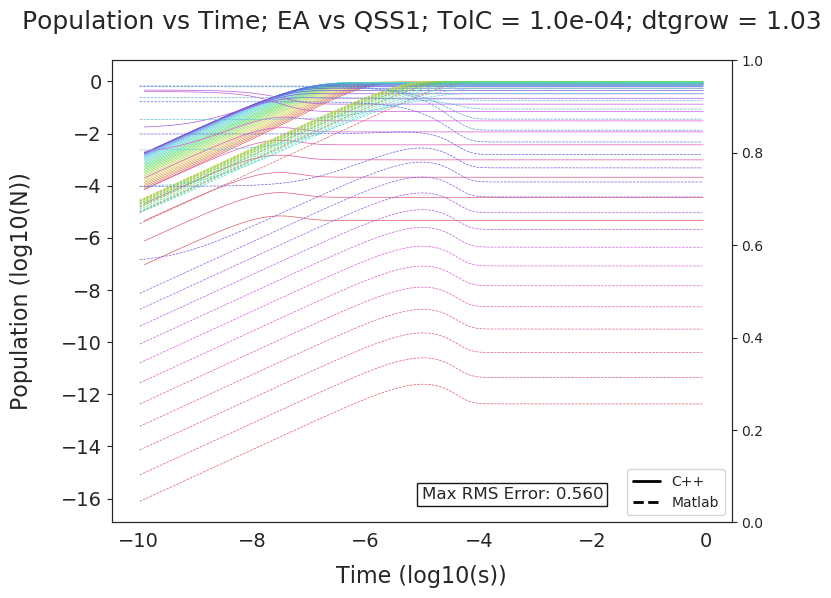

In [5]:
# Perform the RMS error calculation for each time step
RMS_array_cpp = np.zeros((99,))
RMS_array_matlab = np.zeros((99,))
for i in range(1, 100):
    # Get the reference and approximation calculations for this time step
    R = N_array_matlab[i, :]
    A = N_array_cpp[i - 1, :].reshape(N_array_matlab.shape[1], -1)

    # Calculate the residuals for each N value and sum them
    Res = np.abs(A - R)

    # Calculate the RMS error for C++ data
    RMS_cpp = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))
    RMS_array_cpp[i - 1] = RMS_cpp

    # Calculate the RMS error for Matlab data
    RMS_matlab = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))
    RMS_array_matlab[i - 1] = RMS_matlab

# Find the maximum RMS error and the time step at which it occurs for each case
max_RMS_error_cpp = np.max(RMS_array_cpp)
max_error_idx_cpp = np.unravel_index(np.argmax(RMS_array_cpp, axis=None), RMS_array_cpp.shape)
max_error_time_cpp = t_array_matlab[max_error_idx_cpp[0]]

max_RMS_error_matlab = np.max(RMS_array_matlab)
max_error_idx_matlab = np.unravel_index(np.argmax(RMS_array_matlab, axis=None), RMS_array_matlab.shape)
max_error_time_matlab = t_array_matlab[max_error_idx_matlab[0]]

# Set up the plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the 'colors' variable using hls_palette
num_colors = N_log_array_cpp.shape[2]
colors = sns.color_palette("hls", num_colors)

# Plot C++ data with straight lines
for i in range(N_log_array_cpp.shape[2]):
    ax.plot(t_log_array_cpp[1:], N_log_array_cpp[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2)

# Plot Matlab data with dashed lines
for i in range(N_log_array_matlab.shape[2]):
    ax.plot(t_log_array_matlab[1:], N_log_array_matlab[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

ax.set_xlabel("Time (log10(s))", fontsize=16, labelpad=10)
ax.set_ylabel("Population (log10(N))", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add title
ax.set_title("Population vs Time; EA vs QSS1; TolC = 1.0e-04; dtgrow = 1.03", fontsize=18, y=1.05)

# Create a custom legend with visual distinctions
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

ax.legend(custom_lines, ['C++', 'Matlab'], loc='lower right')

# Add RMS error box with a smaller size
ax.text(0.50, 0.05, f"Max RMS Error: {max_RMS_error_cpp:.3f}", transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, pad=3))

# Create a separate axis for the error plot
ax2 = ax.twinx()
ax2.plot(t_array_matlab[1:], RMS_array_cpp, color='red', alpha=0.8, linewidth=1.5)
ax2.set_ylabel("RMS Error (C++)", fontsize=14, labelpad=12, color='red')
ax2.tick_params(axis='y', labelsize=12, colors='red')
ax2.spines['right'].set_color('red')
ax2.spines['right'].set_linewidth(1.5)
ax2.yaxis.label.set_color('red')

plt.show()


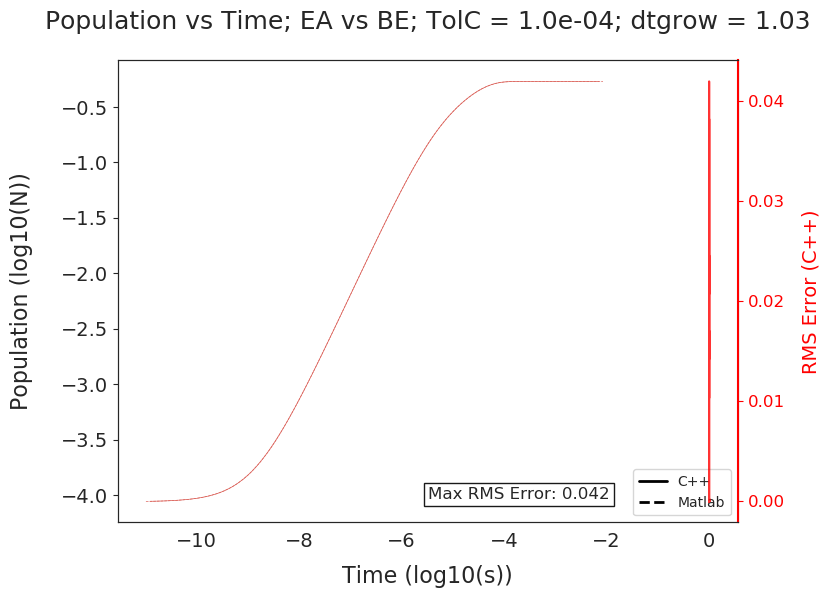

In [5]:

max_error_N_idx = np.argmax(Res)


sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the 'colors' variable using hls_palette
colors = sns.color_palette("hls", 1)


ax.plot(t_log_array_cpp[1:], N_log_array_cpp[1:, :, max_error_N_idx], c=colors[0], alpha=0.98, linewidth=0.5, zorder=2)


ax.plot(t_log_array_matlab[1:], N_log_array_matlab[1:, :, max_error_N_idx], c=colors[0], alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

ax.set_xlabel("Time (log10(s))", fontsize=16, labelpad=10)
ax.set_ylabel("Population (log10(N))", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14)


ax.set_title("Population vs Time; EA vs BE; TolC = 1.0e-04; dtgrow = 1.03", fontsize=18, y=1.05)


custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

ax.legend(custom_lines, ['C++', 'Matlab'], loc='lower right')

ax.text(0.50, 0.05, f"Max RMS Error: {max_RMS_error_cpp:.3f}", transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, pad=3))

ax2 = ax.twinx()
ax2.plot(t_array_matlab[1:], RMS_array_cpp, color='red', alpha=0.8, linewidth=1.5)
ax2.set_ylabel("RMS Error (C++)", fontsize=14, labelpad=12, color='red')
ax2.tick_params(axis='y', labelsize=12, colors='red')
ax2.spines['right'].set_color('red')
ax2.spines['right'].set_linewidth(1.5)
ax2.yaxis.label.set_color('red')

plt.show()


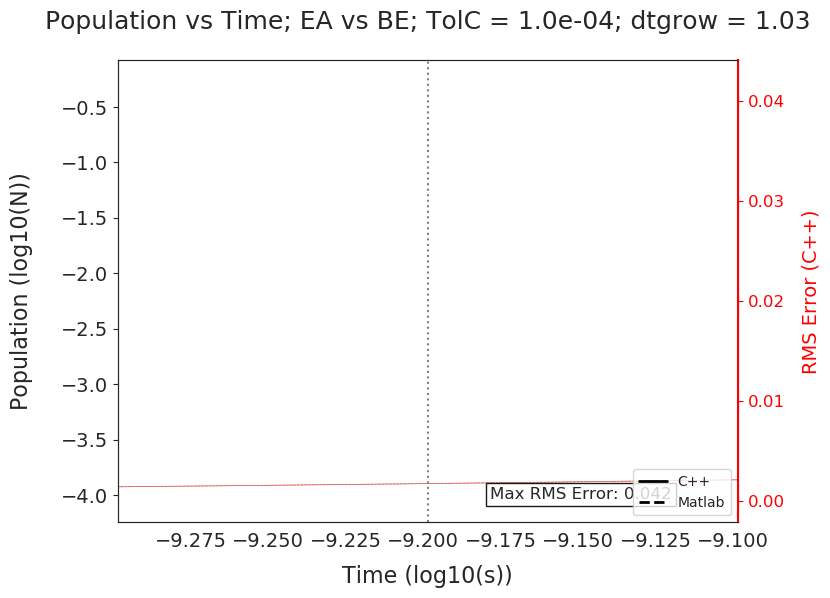

In [6]:
max_error_time = t_log_array_cpp[1:][max_error_N_idx]

sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

colors = sns.color_palette("hls", 1)

ax.plot(t_log_array_cpp[1:], N_log_array_cpp[1:, :, max_error_N_idx], c=colors[0], alpha=0.98, linewidth=0.5, zorder=2)
ax.plot(t_log_array_matlab[1:], N_log_array_matlab[1:, :, max_error_N_idx], c=colors[0], alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

ax.set_xlabel("Time (log10(s))", fontsize=16, labelpad=10)
ax.set_ylabel("Population (log10(N))", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_title("Population vs Time; EA vs BE; TolC = 1.0e-04; dtgrow = 1.03", fontsize=18, y=1.05)

custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

ax.legend(custom_lines, ['C++', 'Matlab'], loc='lower right')

ax.text(0.60, 0.05, f"Max RMS Error: {max_RMS_error_cpp:.3f}", transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, pad=3))

ax2 = ax.twinx()
ax2.plot(t_array_matlab[1:], RMS_array_cpp, color='red', alpha=0.8, linewidth=1.5)
ax2.set_ylabel("RMS Error (C++)", fontsize=14, labelpad=12, color='red')
ax2.tick_params(axis='y', labelsize=12, colors='red')
ax2.spines['right'].set_color('red')
ax2.spines['right'].set_linewidth(1.5)
ax2.yaxis.label.set_color('red')

# Add vertical line at the time of maximum error
ax.axvline(x=max_error_time, color='gray', linestyle=':', linewidth=1.5)

# Set x-axis limits to focus on the specific time
ax.set_xlim(max_error_time - 0.1, max_error_time + 0.1)

plt.show()
